https://github.com/AdityaVashista30/Image-generation-using-GANS-using-PyTorch-and-Cifar-10

https://github.com/soumith/dcgan.torch/issues/2#issuecomment-164862299

In [1]:
#torch cuda
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Importing the libraries
import os
import numpy as np
from PIL import Image
import cv2
import numpy as np
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import errno

# Seteamos algunos hiperparametros que necesitaremos
batchSize = 32 #tamaño del batch
imageSize = 128 #tamaño de imagen
nz = 100 #tamaño de input del generador
ngf = 128 #tamaño de input del generador
ndf = int(ngf/4) #tamaño de input del discriminador
nc = 1 #numero de canales (1 porque trabajamos en escala de grises)


#Definimos una clase para cargar el dataset
class CustomDataset(data.Dataset):
    def __init__(self, X_folder, y_folder, transform=None):
        self.X_folder = X_folder
        self.y_folder = y_folder
        self.transform = transform

        # Obtener la lista de nombres de archivo en las carpetas
        self.X_filenames = [filename for filename in os.listdir(X_folder) if filename.endswith('.jpg')]
        self.y_filenames = [filename for filename in os.listdir(y_folder) if filename.endswith('.jpg')]

    def __len__(self):
        return len(self.X_filenames)

    def __getitem__(self, index):
        # Obtener el nombre de archivo correspondiente a la posición del índice
        X_filename = self.X_filenames[index]
        y_filename = self.y_filenames[index]

        # Verificar si el archivo tiene la extensión ".jpg"
        if not X_filename.endswith(".jpg"):
            return self.__getitem__((index + 1) % len(self))

        # Cargar las imágenes y las etiquetas
        X = Image.open(os.path.join(self.X_folder, X_filename)).convert("RGB")
        y = Image.open(os.path.join(self.y_folder, y_filename)).convert("RGB")

        if self.transform:
            X = self.transform(X)
            y = self.transform(y)

        return X, y

    def get_images(self):
        images = []
        for X_filename in self.X_filenames:
            X = Image.open(os.path.join(self.X_folder, X_filename))
            if self.transform:
                X = self.transform(X)
            images.append(X)
        return images

    def get_labels(self):
            labels = []
            for y_filename in self.y_filenames:
                y = Image.open(os.path.join(self.y_folder, y_filename))
                if self.transform:
                    y = self.transform(y)
                labels.append(y)
            return labels


# Definimos las rutas de las carpetas de entrenamiento y prueba
trainX_folder = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/CRACK500/traindata/traindata/'
trainy_folder = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/CRACK500/valdata/valdata/'

# Creamos las transformaciones
transform = transforms.Compose([
    transforms.Resize((imageSize,imageSize)), #Ajuste de resolución
    transforms.Grayscale(), #Pasamos a escala de grises
    transforms.ToTensor(), #Convertimos en tensor
    transforms.Normalize((0.5), (0.5)),
])

# Creamos el dataset personalizado de entrenamiento
dataset_full = CustomDataset(trainX_folder, trainy_folder, transform=transform)
dataset = dataset_full.get_images()

# Creamos el dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=2)

# Definimos una función para inicializar los pesos tomando como entrada una red neuronal
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Creamos la clase que define el generador
class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            # La entrada será de tamaño nz, en este caso 100 y pasamos por una
            # capa de convolución transpuesta con salida ngf*16=2048
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # Pasamos por varias capas de convolucón transpuesta, reduciendo así
            # el tamaño. ngf = 128
            # (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 128 x 128
            # La salida será 1x128x128
        )


    def forward(self, input):
        output = self.main(input)
        return output

# Creamos el generador y lo pasamos a la GPU
netG = G().to(device)
netG.apply(weights_init)

# Definimos la clase del discriminador
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            # La entrada será (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # 1
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)


# Creamos el discriminador y lo pasamos a la GPU
netD = D().to(device)
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

In [ ]:
!pip3 install torchview
!pip3 install graphviz

In [ ]:
from torchview import draw_graph
from torchvision.transforms import ToPILImage
import graphviz


model_gen = G()
model_dis = D()

# Obtén el gráfico del modelo
model_graph_gen = draw_graph(model_gen, input_size=(1, 100, 1, 1), device='meta')
visual_graph_gen = model_graph_gen.visual_graph

# Ajusta los estilos del grafo generador
visual_graph_gen.attr('node', shape='plain', style='filled', color='white')
visual_graph_gen.attr('graph', bgcolor='transparent')
#visual_graph_gen.attr(size='10,10!', margin='0.1')

# Guarda el gráfico en formato DOT
dot_path_gen = "modelo_gan_gen.dot"
visual_graph_gen.save(dot_path_gen)

# Convierte el archivo DOT a una imagen PNG usando Graphviz
output_path_gen = "/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/NN_Structure/modelo_gan_gen"
graph_gen = graphviz.Source.from_file(dot_path_gen)
graph_gen.render(output_path_gen, format='pdf')

# Obtén el gráfico del modelo
model_graph_dis = draw_graph(model_dis, input_size=(128, 1, 128, 128), device='meta')
visual_graph_dis = model_graph_dis.visual_graph

# Ajusta los estilos del grafo discriminador
visual_graph_dis.attr('node', shape='plain', style='filled', color='white')
visual_graph_dis.attr('graph', bgcolor='transparent')

# Guarda el gráfico en formato DOT
dot_path_dis = "modelo_gan_dis.dot"
visual_graph_dis.save(dot_path_dis)

# Convierte el archivo DOT a una imagen PNG usando Graphviz
output_path_dis = "/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/NN_Structure/modelo_gan_dis"
graph_dis = graphviz.Source.from_file(dot_path_dis)
graph_dis.render(output_path_dis, format='pdf')



'/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_1/NN_Structure/modelo_gan_dis.pdf'

In [4]:
# Listas para almacenar los valores de loss
loss_G_values = []
loss_D_values = []

# Comenzamos el entranamiento del GAN
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))
#optimizerD = optim.SGD(netD.parameters(), lr=0.01, momentum=0.9)
#optimizerG = optim.SGD(netG.parameters(), lr=0.01, momentum=0.9)

#Generamos carpetas para almacenar las imágenes creadas
try:
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/Images')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/Images/fake_samples')
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise



for epoch in range(200):
    for i, data in enumerate(dataloader, 0): # iteramos sobre las imágenes del dataset
        # 1er paso: actualizamos los pesos de la red neuronal del discriminador
        netD.zero_grad()
        real = data.to(device) # Imagen real del dataset
        input = Variable(real).to(device) # la almacenamos en una variable
        target = torch.tensor(torch.ones(input.size()[0])).to(device) # Creamos el target
        output = netD(input)
        errD_real = criterion(output, target)
        # Entrenamos el discrimnador con una imagen false generada por el generador a partir de ruido
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0])).to(device)
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        # Propagación hacia atrás de los errores del discriminador
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2º paso: actualizamos los pesos de la red neuronal del generador

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        #3er paso: Almaceno los valores de loss
        loss_G_values.append(errG.item())
        loss_D_values.append(errD.item())

        # 4º paso: Sacamos por pantalla las pérdidas y alamacenamos un ejemplo de imagen real y las imagenes generadas del minibatch cada 100 pasos

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch+1, 200, i+1, len(dataloader), errD.data, errG.data))
        if i % 100 == 0: # Cada 100 pasos:
            vutils.save_image(real.cpu(), '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/Images/real_samples.png', normalize = True) # We save the real images of the minibatch.
            fake = netG(noise)
            vutils.save_image(fake.detach().cpu(), f'/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/Images/fake_samples/fake_samples_epoch_{epoch:03d}.png', normalize=True) # We also save the fake generated images of the minibatch.

<ipython-input-4-c15058fb8db1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(torch.ones(input.size()[0])).to(device) # Creamos el target


[1/200][1/8] Loss_D: 1.3662 Loss_G: 6.5222
[1/200][2/8] Loss_D: 4.5356 Loss_G: 4.4840
[1/200][3/8] Loss_D: 5.6524 Loss_G: 4.5870
[1/200][4/8] Loss_D: 6.2025 Loss_G: 5.0547
[1/200][5/8] Loss_D: 6.1274 Loss_G: 5.8162
[1/200][6/8] Loss_D: 6.0166 Loss_G: 7.0548
[1/200][7/8] Loss_D: 5.4569 Loss_G: 8.1191
[1/200][8/8] Loss_D: 5.0403 Loss_G: 9.1639
[2/200][1/8] Loss_D: 2.7943 Loss_G: 10.1597
[2/200][2/8] Loss_D: 3.2497 Loss_G: 10.6236
[2/200][3/8] Loss_D: 3.6605 Loss_G: 11.1062
[2/200][4/8] Loss_D: 4.4431 Loss_G: 11.7342
[2/200][5/8] Loss_D: 3.1051 Loss_G: 12.4724
[2/200][6/8] Loss_D: 2.3475 Loss_G: 11.8424
[2/200][7/8] Loss_D: 4.3193 Loss_G: 12.5443
[2/200][8/8] Loss_D: 3.7525 Loss_G: 12.0323
[3/200][1/8] Loss_D: 3.4695 Loss_G: 13.2361
[3/200][2/8] Loss_D: 2.2703 Loss_G: 10.9789
[3/200][3/8] Loss_D: 3.8909 Loss_G: 13.9837
[3/200][4/8] Loss_D: 1.7112 Loss_G: 9.8069
[3/200][5/8] Loss_D: 5.4168 Loss_G: 12.7824
[3/200][6/8] Loss_D: 1.9416 Loss_G: 12.0625
[3/200][7/8] Loss_D: 2.8778 Loss_G: 11.41

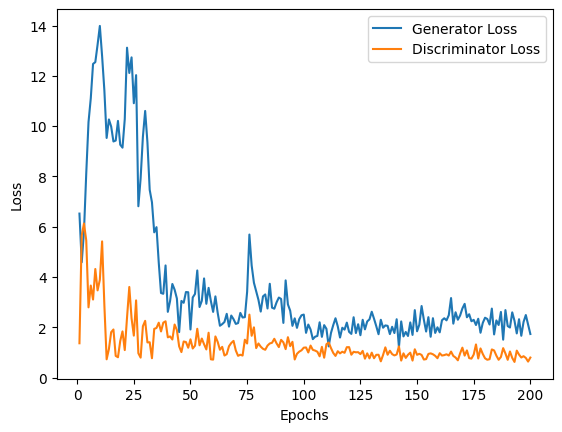

In [5]:
import matplotlib.pyplot as plt
# Generar gráfica del loss del generador y del discriminador
epochs = range(1, 201)  # Número total de epochs
plt.plot(epochs, loss_G_values[0:400:2], label='Generator Loss')
plt.plot(epochs, loss_D_values[0:400:2], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Guardar la gráfica como un archivo .png
plt.savefig('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/loss_graph.png')

# Mostrar la gráfica en pantalla
plt.show()

In [8]:
# Guardamos el modelo en un archivo .pth
gen_path = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models/generator.pth'
dis_path = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models/discriminator.pth'

torch.save(netG.state_dict(), gen_path)
torch.save(netD.state_dict(), dis_path)

# Función para generar una imagen aleatoria y guardarla en un archivo .jpg
def generar_imagen_aleatoria(generator_path, output_path):
    # Cargamos los pesos del generador desde el archivo .pth
    generator = G()
    generator.load_state_dict(torch.load(generator_path))
    generator.eval()

    # Generamos una imagen aleatoria
    with torch.no_grad():
        noise = torch.randn(1, 100, 1, 1)
        imagen_generada = generator(noise)

    # Guardamos la imagen generada en un archivo .jpg
    vutils.save_image(imagen_generada, output_path, normalize=True)

In [9]:
# Generamos 100 imágenes y las almacenamos
try:
    os.mkdir('/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models/fotos_generadas')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

gen_path = '/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models/generator.pth'
for i in range(100):
  generar_imagen_aleatoria(gen_path, f"/content/gdrive/MyDrive/Dev/AI_MsC/TFM/BestNotebooks/GAN-Simple_Pablo_v3_2/models/fotos_generadas/output_{i}.jpg")